# Retrieval as a Tool

Where in the last usage, the retrieval is defined by graph so it can clearly what every steps doing. In the production use, we would like the retrieval as a tool. In this notebook, we will try to create a tool based on the last notebook.

In [72]:
# Prepare environment variable
# You should check env.example file
# It's needed throughout this jupyter notebook
import os
from dotenv import load_dotenv
load_dotenv()

True

# Retrieval Tool

Creating tools meaning we are only doing what the tools intendeed, let the summarizer by the agent it self

In [73]:
# Prepare library
## AI Search related
import langchain_community.vectorstores.azuresearch as azuresearch
from langchain_community.vectorstores.azuresearch import AzureSearch
from langchain_openai import AzureOpenAIEmbeddings

## LLM related
import os
import json
from langchain.chat_models import init_chat_model

## Tool creation related
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, AnyMessage, ToolMessage

In [74]:
# Check if you already prepare the environment file
index_name = "kaenova-testing-3" # You can change it, if you want to
api_version = "2024-12-01-preview"
langchain_model_name = "azure_openai:gpt-4" # Adjust based on what you deployed 

for key in ["AZURE_AIS_ENDPOINT", "AZURE_AIS_KEY", "AZURE_OAI_ENDPOINT", "AZURE_OAI_KEY", "AZURE_OAI_DEPLOYMENT", "AZURE_OAI_CHAT_DEPLOYMENT"]:
    if not os.getenv(key):
        raise ValueError(f"{key} is not provided")

In [75]:
# !important you may change this. Map the fields into the connector library
azuresearch.FIELDS_CONTENT = "chunk"
azuresearch.FIELDS_CONTENT_VECTOR = "chunk_vector"
azuresearch.FIELDS_ID = "id"

In [76]:
# Prepare the embedding function
embeddings : AzureOpenAIEmbeddings = AzureOpenAIEmbeddings(
    azure_deployment=os.getenv("AZURE_OAI_DEPLOYMENT"),
    openai_api_version=api_version,
    azure_endpoint=os.getenv("AZURE_OAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OAI_KEY"),
)

embeddings_function = embeddings.embed_query

In [77]:
# Create Azure AI Search client
vector_store: AzureSearch = AzureSearch(
    azure_search_endpoint=os.getenv("AZURE_AIS_ENDPOINT"),
    azure_search_key=os.getenv("AZURE_AIS_KEY"),
    index_name=index_name,
    embedding_function=embeddings.embed_query,
)

In [78]:
# Prepare LLM for query Expander
os.environ["AZURE_OPENAI_API_KEY"] = os.getenv("AZURE_OAI_KEY")
os.environ["AZURE_OPENAI_ENDPOINT"] = os.getenv("AZURE_OAI_ENDPOINT")
os.environ["OPENAI_API_VERSION"] = api_version

chat_llm = init_chat_model(
    langchain_model_name,
    azure_deployment=os.environ["AZURE_OAI_CHAT_DEPLOYMENT"],
)

In [79]:
# Define the steps of retrieval flow
def expand_query(questions: str) -> list[str]:
    system_prompt = (
        "You're a search query expander, you'll get a user question and you need to create multiple concise, keyworded, and general search query"
        "That'll be injected to the Azure AI Search"
        "Return the question only in JSON array without any codeblocks"
        "You'll only return like \'[\"query_1\", \"query_2\", \"query_3\", \"query_4\", \"query_5\"]\'"
    )

    valid = False
    data = []
    while not valid:
        result = chat_llm.invoke([SystemMessage(content=system_prompt), HumanMessage(content=questions)])
        print("[expand_query] llm_result", result.content)
        
        try:
            data = json.loads(result.content)
            if type(data) is list:
                valid = True
        except:
            print("[expand_query] not a valid value")

    return data

def unique_dicts(list_of_dicts):
    """
    Returns a unique list of dictionaries based on the 'id' key.

    Args:
        list_of_dicts: A list of dictionaries.

    Returns:
        A new list containing only the unique dictionaries.
    """
    unique_ids = set()
    unique_list = []
    for d in list_of_dicts:
        if d['id'] not in unique_ids:
            unique_ids.add(d['id'])
            unique_list.append(d)
    return unique_list

def retrieve_documents(questions: list[str]) -> list[str]:
    retrieved_chunks = []
    for question in questions:
        answers = vector_store.semantic_hybrid_search(
            query=question, k=3,
        )
        for x in answers:
            chunk_data = {
                "id": x.metadata['id'],
                "content": x.page_content
            }
            retrieved_chunks.append(chunk_data)
    final_chunks = unique_dicts(retrieved_chunks)
    return final_chunks

In [80]:
# Creating the tool itself

@tool
def retrieve_tool(questions: str) -> list[str]:
    """Tool to retrieve document based on the questions related. This will return a json of related documents. Mainly this is a Indonesian Document, so your questions should be in Indonesian."""
    generated_questions = expand_query(questions)
    data = retrieve_documents(generated_questions)
    print("[retrieve_tool]", str(data))
    tool_output = "Chunk Data\n```"
    for x in data:
        tool_output += f"\n<data><id>{x["id"]}</id><chunk>{x["content"]}</chunk>/data>"
    tool_output += "\n```"
    return tool_output

In [81]:
# Let's try the tool first
print(retrieve_tool("Kapan Gerakan perempuan?")[:1])

[expand_query] llm_result ["Sejarah gerakan perempuan", "Timeline gerakan hak perempuan", "Perkembangan gerakan feminisme", "Kapan dimulai gerakan perempuan?", "Milestones penting gerakan perempuan"]
[retrieve_tool] [{'id': '75f218c9a1341be9b298ed3848d7c055__chunk_0045', 'content': 'banyak kelompok yang memiliki massa, baik yang berbasis ideologi \npolitik maupun agama. Kekuatan kelompok tersebut memunculkan warna \nyang beragam pada identitas nasional dan berbagai peristiwa sejarah di \nIndonesia. Beberapa di antaranya akan dibahas pada subbab berikut.\n1.\t Gerakan Perempuan \nGerakan Perempuan pada tahun 1950—1960 merupakan salah satu \nperiode pergerakan paling progresif setelah tahun 1928. Pada periode ini \nbanyak organisasi perempuan yang berafiliasi dengan kekuatan-kekuatan \norganisasi massa yang besar. Sebagai contoh Aisyiah dari Muhammadiyah, \nMuslimat dari Masyumi, Muslimat Nahdlatul Ulama (NU) dari NU, Perwari, \ndan juga Gerakan Wanita Istri Sedar (Gerwis). Gerwis merupa

# Create langgraph chat agent

In [82]:
# Prepare library
## LLM related
import os
import json
from langchain.chat_models import init_chat_model

## State related
from typing import Annotated, Literal
from typing_extensions import TypedDict

## Graph Related
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, AnyMessage

## Graph Related Memory
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

In [83]:
# Check if you already prepare the environment file
api_version = "2024-12-01-preview"
langchain_model_name = "azure_openai:gpt-4" # Adjust based on what you deployed 

for key in ["AZURE_OAI_ENDPOINT", "AZURE_OAI_KEY", "AZURE_OAI_CHAT_DEPLOYMENT"]:
    if not os.getenv(key):
        raise ValueError(f"{key} is not provided")

In [84]:
# Prepare langgraph state 
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages] # To keep chat threads

In [85]:
# Prepare Graph
## Prepare langgraph llm initialization
os.environ["AZURE_OPENAI_API_KEY"] = os.getenv("AZURE_OAI_KEY")
os.environ["AZURE_OPENAI_ENDPOINT"] = os.getenv("AZURE_OAI_ENDPOINT")
os.environ["OPENAI_API_VERSION"] = api_version

chat_llm = init_chat_model(
    langchain_model_name,
    azure_deployment=os.environ["AZURE_OAI_CHAT_DEPLOYMENT"],
)

## Prepare tool integration with the llm
tools = [retrieve_tool]
tools_by_name = {tool.name: tool for tool in tools}
chat_llm_with_tools = chat_llm.bind_tools(tools)

## Define Node for LLM
def llm_node(state: State):
    """LLM decides whether to call a tool or not"""
    return {
        "messages": [
            chat_llm_with_tools.invoke(
                [
                    SystemMessage(
                        content=(
                            "You are a helpful assistant that can do retrieval using the retrieval tools."
                            "The retrieval tools helps you to get data. Analyze the user intention and decide wether you need to use tools or not."
                            "When retrieving documents, cite the document id"
                        )
                    )
                ]
                + state["messages"]
            )
        ],
    }

## Define Node for Tool Calling
def retrieve_tool_node(state: State):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


## Define Condition when to use tools
def llm_node_conditions(state: State) -> Literal["retrieve_tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "retrieve_tool_node"
    # Otherwise, we stop (reply to the user)
    return END

In [86]:
# Build Graph
## Prepare Graph Builder
graph_builder = StateGraph(State)

## Add nodes
graph_builder.add_node("llm_node", llm_node)
graph_builder.add_node("retrieve_tool_node", retrieve_tool_node)

## Add edges
graph_builder.add_edge(START, "llm_node")
graph_builder.add_conditional_edges(
    "llm_node",
    llm_node_conditions,
    ["retrieve_tool_node", END]
)
graph_builder.add_edge("retrieve_tool_node", "llm_node")

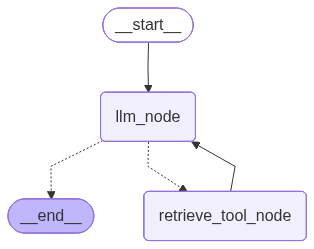

In [87]:
# Compile Graph w/ Saving the State

## Prepare Database for Saving the state (checkpoint)
conn = sqlite3.connect("checkpoints.sqlite", check_same_thread=False)
memory = SqliteSaver(conn)

## Prepare the graph
graph = graph_builder.compile(checkpointer=memory)

display(graph)

# Let's Chat w/ Tools

In [90]:
def stream_chat(chat_id: str):
    config = {"configurable": {"thread_id": chat_id}}
    while True:
        user_input = input("> ")
        if user_input in ["q", "quit", "\\q"]:
            print("Goodbye!")
            break
        messages = [HumanMessage(content=user_input)]
        for chunk in graph.stream({"messages": messages}, stream_mode="updates", config=config):
            print(chunk)
            print("\n")

In [91]:
## Prepare the graph session for the checkpoint
chat_id = "unique-id-06"
stream_chat(chat_id)

>  Halo! ini prompt pertama saya


{'llm_node': {'messages': [AIMessage(content='Halo! Selamat datang! Apakah ada yang bisa saya bantu hari ini?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 113, 'total_tokens': 133, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_5603ee5e2e', 'id': 'chatcmpl-CGGFlFoyaF2ogZyUaWB4sXlS4ntnq', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'filtered': False, 'detected': False}, 'protected

>  Saya ingin mengetahui apa saja yang bisa kamu lakukan?


{'llm_node': {'messages': [AIMessage(content='Saya dapat membantu Anda dengan berbagai tugas, termasuk:\n\n1. **Mencari Informasi**: Saya dapat membantu mencari informasi atau dokumen yang berkaitan dengan pertanyaan Anda.\n2. **Analisis Data**: Saya dapat membantu menganalisis data dan memberikan wawasan berdasarkan analisis tersebut.\n3. **Ringkasan**: Saya dapat membuat ringkasan dari teks atau dokumen yang panjang.\n4. **Penerjemahan Bahasa**: Saya bisa menerjemahkan teks ke berbagai bahasa.\n5. **Pembelajaran dan Rekomendasi**: Saya dapat memberikan pelajaran tentang berbagai topik atau memberikan rekomendasi berdasarkan preferensi Anda.\n6. **Bantuan Teknis**: Saya bisa membantu dengan pertanyaan atau masalah teknis yang mungkin Anda miliki.\n\nSilakan beritahu saya lebih spesifik tentang apa yang Anda perlukan bantuan, sehingga saya dapat memberikan jawaban atau solusi yang paling relevan!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_toke

>  Bisakah kamu mencari mengenai tentang Bandung Lautan api? Itu kapan ya terjadinya?


{'llm_node': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kf4K2ImO3kQifpfJMrnbuzh6', 'function': {'arguments': '{"questions":"When did the Bandung Sea of Fire occur?"}', 'name': 'retrieve_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 421, 'total_tokens': 444, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_5603ee5e2e', 'id': 'chatcmpl-CGGGeypXodL3BH2ygo0YsffxQpSXG', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_result

>  Apa yang terjadi pada 23 Marekt 1946?


{'llm_node': {'messages': [AIMessage(content='Pada tanggal 23 Maret 1946, terjadi sebuah peristiwa penting dalam sejarah perjuangan Indonesia yaitu Bandung Lautan Api. Peristiwa ini terjadi ketika Sekutu, yang diboncengi oleh NICA, hadir di Bandung dan menuntut agar rakyat Indonesia menyerahkan senjata mereka dan mengambil alih berbagai fasilitas.\n\nDalam situasi ini, para pejuang Indonesia, yang saat itu kekuatan senjatanya terbatas dan tidak ingin terjadi pertumpahan darah lebih lanjut, memutuskan untuk melakukan taktik bumi hangus di Bandung. Mereka memutuskan untuk membakar bagian selatan kota Bandung sebagai bagian dari strategi perang untuk mencegah fasilitas-fasilitas di sana dimanfaatkan oleh Sekutu.\n\nStrategi ini merupakan bentuk perlawanan dan menghindari konfrontasi langsung yang berdarah dengan kekuatan bersenjata Sekutu yang jauh lebih superior. Ini juga menunjukkan semangat dan determinasi pejuang Indonesia untuk mempertahankan kemerdekaan dari kekuatan asing yang ingi

>  Apa prompt pertama saya?


{'llm_node': {'messages': [AIMessage(content='Prompt pertama Anda adalah: "Halo! ini prompt pertama saya"', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 10887, 'total_tokens': 10904, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_5603ee5e2e', 'id': 'chatcmpl-CGGIVzYPveSBeLIQeHen6gX6uRilb', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'filtered': False, 'detected': False}, 'protected

>  Woo memory kamu berjalan!


{'llm_node': {'messages': [AIMessage(content='Terima kasih! Senang bisa membantu Anda. Jika ada pertanyaan atau informasi lain yang Anda butuhkan, jangan ragu untuk bertanya!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 10919, 'total_tokens': 10956, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_5603ee5e2e', 'id': 'chatcmpl-CGGIhicRIjeBY6g7BoaDy21vv3poa', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_ha

>  q


Goodbye!
